In [ ]:
!pip install -q torch==1.10.0 torchvision

     |██████████████████████████████▎ | 834.1 MB 35.7 MB/s eta 0:00:02tcmalloc: large alloc 1147494400 bytes == 0x55624858a000 @  0x7f7017375615 0x55620fefd4cc 0x55620ffdd47a 0x55620ff002ed 0x55620fff1e1d 0x55620ff73e99 0x55620ff6e9ee 0x55620ff01bda 0x55620ff73d00 0x55620ff6e9ee 0x55620ff01bda 0x55620ff70737 0x55620fff2c66 0x55620ff6fdaf 0x55620fff2c66 0x55620ff6fdaf 0x55620fff2c66 0x55620ff6fdaf 0x55620ff02039 0x55620ff45409 0x55620ff00c52 0x55620ff73c25 0x55620ff6e9ee 0x55620ff01bda 0x55620ff70737 0x55620ff6e9ee 0x55620ff01bda 0x55620ff6f915 0x55620ff01afa 0x55620ff6fc0d 0x55620ff6e9ee
     |████████████████████████████████| 881.9 MB 4.1 kB/s 


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainset.data.shape

(50000, 32, 32, 3)

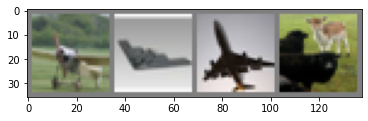

plane plane plane  deer


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x1 = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x1)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = to_device(Net(), device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
trainloader = DeviceDataLoader(trainloader, device)

Epoch loss 1.7504227982672553
Epoch loss 1.3697927987423415
Epoch loss 1.2238403194734517
Epoch loss 1.1200929936508959
Epoch loss 1.0475060932075915


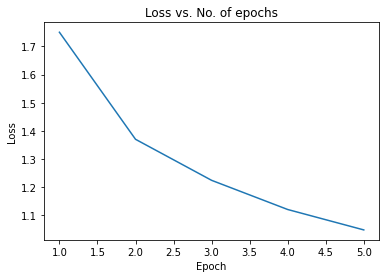

In [ ]:
loss_values = []
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        

        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
    print("Epoch loss " + str(running_loss/12000))
    loss_values.append(running_loss / 12000)
    running_loss = 0.0   

x = np.arange(1, 6, 1)
plt.plot(x, loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
PATH = './cifar_net.pth'
#torch.save(net.state_dict(), PATH)

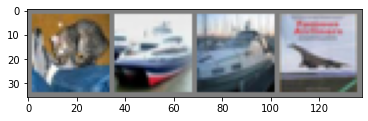

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
print(testloader.dataset.data.shape)
print(images.shape)

(10000, 32, 32, 3)
torch.Size([4, 3, 32, 32])


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)
conv1_output = F.relu(net.conv1(images[0].unsqueeze(0)))

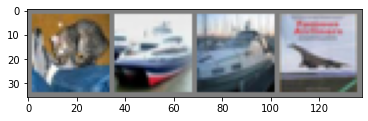

Predicted:    cat  ship  ship  ship


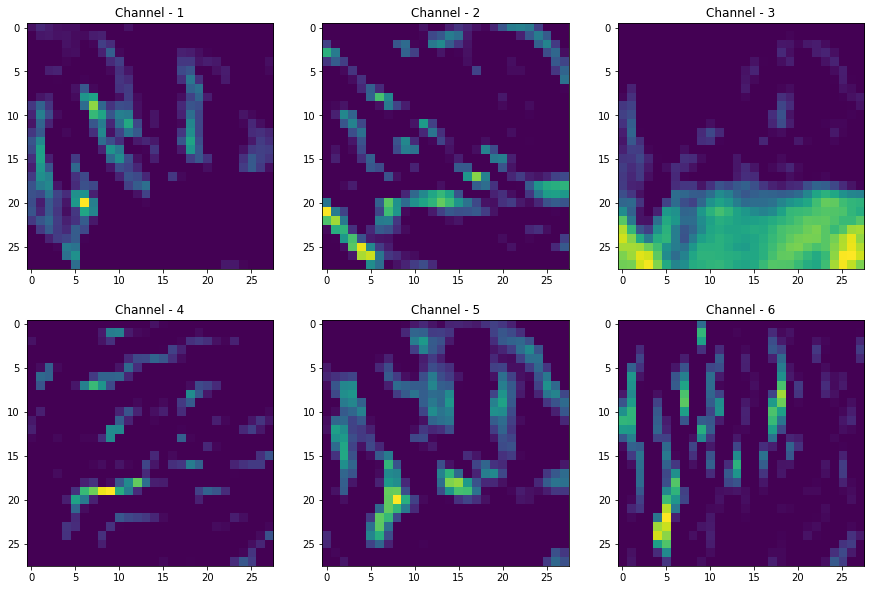

In [ ]:
_, predicted = torch.max(outputs[0], 1)
imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
fig, axs = plt.subplots(2,3, figsize=(15, 10))
j=0
for i in range(6):
  ax1= fig.add_subplot(2,3,i+1)
  axs[(j+1)%2, (i+1)%3].axis('off')
  ax1.title.set_text("Channel - " + str(i+1))  
  plt.imshow(conv1_output[0, i].cpu().detach())
  j+=1

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 69.9 %
Accuracy for class car   is: 79.6 %
Accuracy for class bird  is: 44.2 %
Accuracy for class cat   is: 56.4 %
Accuracy for class deer  is: 53.3 %
Accuracy for class dog   is: 40.2 %
Accuracy for class frog  is: 65.6 %
Accuracy for class horse is: 67.3 %
Accuracy for class ship  is: 79.8 %
Accuracy for class truck is: 63.2 %
